In [9]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

(images, labels), (test_images, test_labels) = mnist.load_data()

images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255

train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [10]:
# 재사용이 가능한 모델 정의 함수
def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

### 사용자 정의 지표 만들기


In [11]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric): # metric 클래스 상속
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)

        ### Define state variable ###
        # 상태 변수 mse_sum는 모든 배치에서 계산된 MSE의 합계를 저장, 0.0 스칼라
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        # 상태 변수 total_samples 현재까지 처리된 전체 샘플의 개수, 0 정수형 스칼라
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred : 각 클래스에 대한 확률값
        # y_true : 정수형 레이블 -> y_pred shape에 맞춰서 one hot encoding
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        # 현재 배치에서 발생한 y_true(target)와 y_pred(predition)의 mse를 계산
        mse = tf.reduce_sum(tf.square(y_true - y_pred))

        ### update state variables ###
        # 상태 변수 mse_sum에 각 배치에서 발생한 mse를 누적
        self.mse_sum.assign_add(mse)
        # 상태 변수 total_samples에 현재 배치의 샘플 개수를 구하여 누적
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        ### return the current metric value ###
        # self.mse_sum / tf.cast(self.total_samples, tf.float32) -> average mse
        # tf.sqrt() -> rmse
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        # 객체를 다시 생성하지 않고 상태를 초기화
        #  - metric object 하나를 서로 다른 훈련 반복에 사용
        #  - 혹은 훈련과 평가에 모두 사용
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [12]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])

model.fit(train_images, train_labels, epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8597 - loss: 0.4619 - rmse: 0.4435 - val_accuracy: 0.9599 - val_loss: 0.1428 - val_rmse: 0.2481
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9497 - loss: 0.1722 - rmse: 0.2769 - val_accuracy: 0.9665 - val_loss: 0.1151 - val_rmse: 0.2244
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9617 - loss: 0.1326 - rmse: 0.2414 - val_accuracy: 0.9711 - val_loss: 0.1086 - val_rmse: 0.2120
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9676 - loss: 0.1194 - rmse: 0.2242


### 사용자 정의 콜백 모델

In [13]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

val_images = train_images[50000:]
val_labels = train_labels[50000:]
train_images = train_images[:50000]
train_labels = train_labels[:50000]

Epoch 1/2
1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8772 - loss: 0.4040

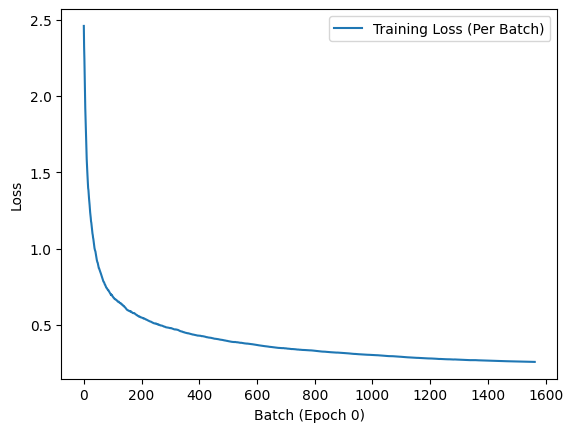

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8774 - loss: 0.4033 - val_accuracy: 0.9623 - val_loss: 0.1296
Epoch 2/2
1555/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9611 - loss: 0.1326

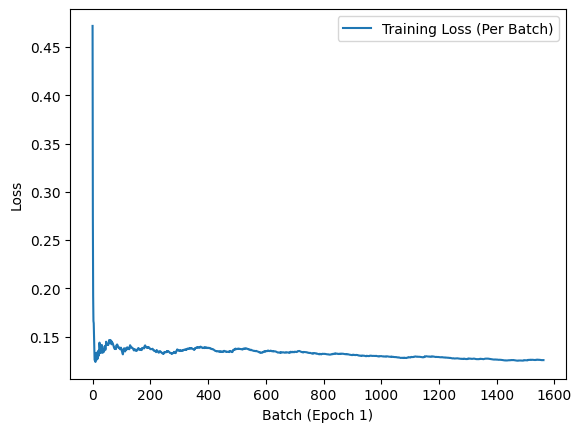

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9611 - loss: 0.1325 - val_accuracy: 0.9716 - val_loss: 0.0970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


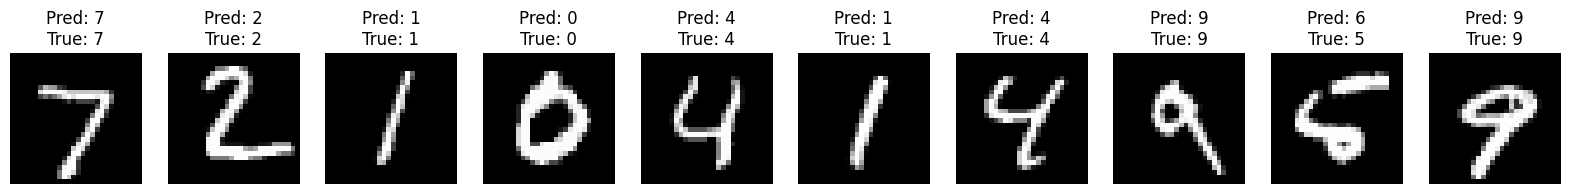

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9649 - loss: 0.1148
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [14]:

# 사용자 정의 콜백 1) 에포크 시 예측 이미지 보이기
class ShowImage(keras.callbacks.Callback):
    def __init__(self, test_images, test_labels):
        super().__init__()
        #부모 클래스인 keras.callbacks.Callback의 초기화 호출
        self.test_images = test_images
        self.test_labels = np.argmax(test_labels, axis=1)
        # 레이블은 원-핫 인코딩된 상태일 수도 있으니 정수로 변환, 이후 실제값 추출

    def on_train_end(self, logs=None):
      # 학습이 끝날 때 호출되는 메서드
        predictions = np.argmax(self.model.predict(self.test_images[:10]), axis=1)
        # 모델로 테스트 이미지를 예측, 10개만.
        # predictions는 모델이 예측한 각 이미지 0~9로 이루어진 어레이인데 이거를 이제 이미지로 보여줄 것
        fig = plt.figure(figsize=(20, 3))
        axes = fig.subplots(1, 10)
        for i, ax in enumerate(axes):
            ax.imshow(self.test_images[i].reshape(28, 28), cmap="gray")
            ax.set_title(f"Pred: {predictions[i]}\nTrue: {self.test_labels[i]}")
            ax.axis("off")
        plt.show()
        plt.close(fig)



class LossHistory(keras.callbacks.Callback):
    # 학습이 시작되면 호출되는 메서드
    def on_train_begin(self, logs=None):
        # 배치별 손실 값을 저장할 리스트를 초기화함.
        self.per_batch_losses = []  # 그냥 빈 리스트 하나 준비

    # 각 배치가 끝날 때 호출되는 메서드
    def on_batch_end(self, batch, logs=None):
        if logs is not None:
            # logs.get('loss')로 현재 배치의 손실 값을 가져옴.
            self.per_batch_losses.append(logs.get('loss'))
            # 학습 상태를 시각적으로 확인하기

    def on_epoch_end(self, epoch, logs=None):
        fig = plt.figure()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses, label='Training Loss (Per Batch)')
        plt.xlabel(f'Batch (Epoch {epoch})')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.close(fig)
        self.per_batch_losses = []

# 모델 정의
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.3)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model


# 모델 생성 및 컴파일
model = get_mnist_model()
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 훈련
model.fit(
    train_images, train_labels,
    epochs=2,
    callbacks=[ShowImage(test_images, test_labels),LossHistory()],
    validation_data=(val_images, val_labels)
)

# 평가
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)


### Colab error : **Graph execution error**
```
NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
```

- Unmatch version between tensorflow and CUDA
- **Check version information**  
    [Build configuration](https://www.tensorflow.org/install/source?hl=ko#gpu)

```ipynb
!nvcc --version
!nvidia-smi
```
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Mon Jan 20 07:51:56 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              25W /  70W |    367MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
+---------------------------------------------------------------------------------------+
```ipynb
import tensorflow as tf
print(tf.__version__)
```
2.17.1